In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
# Merge datasets
merged_df = transactions.merge(customers, on="CustomerID", how="left")
merged_df = merged_df.merge(products, on="ProductID", how="left")

## Feature Engineering

In [4]:
# Aggregate transaction-level data for clustering
customer_features = merged_df.groupby("CustomerID").agg({
    "TotalValue": ["sum", "mean"],        # Total and average spending
    "Quantity": ["sum"],                 # Total quantity purchased
    "Category": lambda x: x.mode()[0],   # Most purchased category
    "Region": "first",                   # Region from customer profile
    "SignupDate": "first"                # Signup date from customer profile
}).reset_index()

customer_features.columns = [
    "CustomerID", "TotalSpending", "AvgSpending", "TotalQuantity",
    "MostPurchasedCategory", "Region", "SignupDate"
]

In [5]:
# Convert signup date to numerical feature
customer_features["SignupDate"] = pd.to_datetime(customer_features["SignupDate"])
customer_features["DaysSinceSignup"] = (pd.Timestamp.now() - customer_features["SignupDate"]).dt.days
customer_features.drop(columns=["SignupDate"], inplace=True)

In [6]:
# Encode categorical variables
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(customer_features[["Region", "MostPurchasedCategory"]]).toarray()

In [7]:
# Normalize numerical features
numerical_features = customer_features[["TotalSpending", "AvgSpending", "TotalQuantity", "DaysSinceSignup"]]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(numerical_features)

# Combine all features
feature_matrix = np.hstack((scaled_features, encoded_features))

## Clustering

In [10]:
# Test different numbers of clusters and calculate DB Index
db_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)
    db_index = davies_bouldin_score(feature_matrix, labels)
    db_scores.append(db_index)

Optimal number of clusters: 8


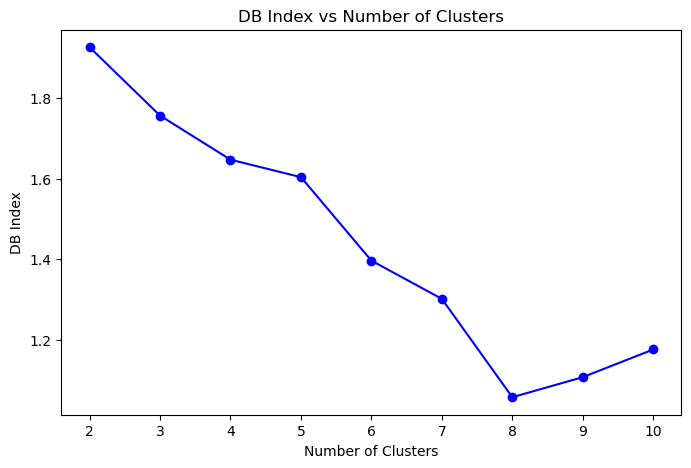

In [14]:
# Optimal number of clusters (lowest DB Index)
optimal_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Plot DB Index vs Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker="o", color="blue")
plt.title("DB Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.show()

In [13]:
# Perform clustering with optimal_k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_labels = final_kmeans.fit_predict(feature_matrix)
customer_features["Cluster"] = final_labels

## Visualizing Clusters

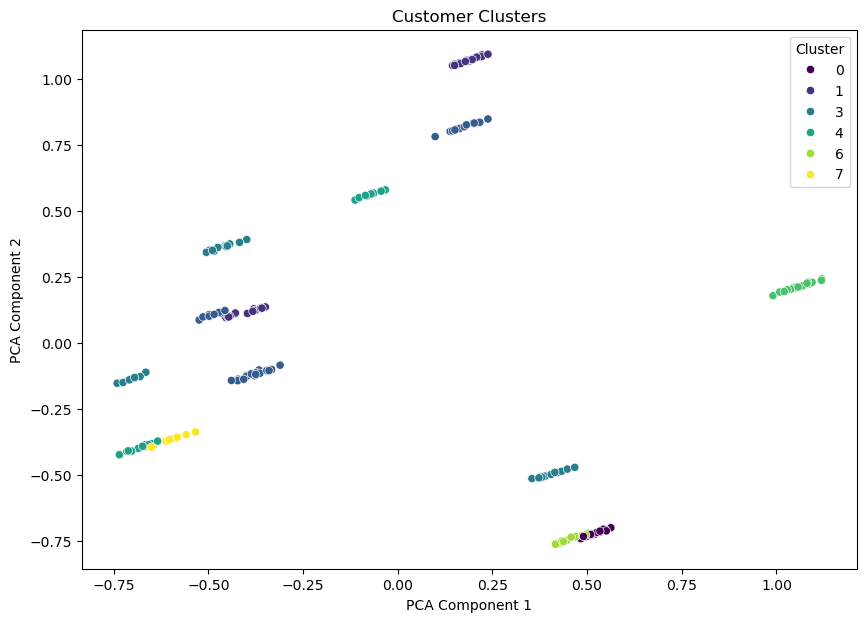

In [15]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(feature_matrix)

# Plot clusters in 2D
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_features["Cluster"], palette="viridis")
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [16]:
# Save cluster assignments and metrics to a file
cluster_results = customer_features[["CustomerID", "Cluster"]]
cluster_results.to_csv("Ajay_K_P_Clustering.csv", index=False)